Some code/ideas of preprocessing taken from: https://www.kaggle.com/code/gauravduttakiit/risk-analytics-in-banking-financial-services-1/notebook

##Import statements and dependencies installation

In [ ]:
!pip install pgmpy networkx pydotplus
!apt install graphviz -y

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import (
    roc_auc_score, f1_score, classification_report, confusion_matrix,
    average_precision_score, brier_score_loss, precision_recall_fscore_support,
    precision_recall_curve
)
from pgmpy.estimators import HillClimbSearch, BDeuScore, K2Score, BicScore, MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from xgboost import XGBClassifier
import networkx as nx

sns.set()
plt.style.use("ggplot")

warnings.filterwarnings("ignore")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


##Initial data prep


Load in the data

In [ ]:
application_data = pd.read_csv("/content/drive/MyDrive/CSE598ProjectFinance/application_data.csv")

print(application_data.shape)
print(application_data.value_counts())
print(application_data['TARGET'].value_counts())

(307511, 122)
SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  NAME_INCOME_TYPE      NAME_EDUCATION_TYPE            NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  OCCUPATION_TYPE        CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  ORGANIZATION_TYPE       EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LA

Missing values insights

Dropping columns: ['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE', 'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'LANDAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'ELEVATORS_MEDI', 'ELEVATORS_AVG', 'ELEVATORS_MODE', 'WALLSMATERIAL_MODE', 'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'APARTMENTS_MODE', 'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE', 'LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'HOUSETYPE_MODE'] due to >50% missing values.


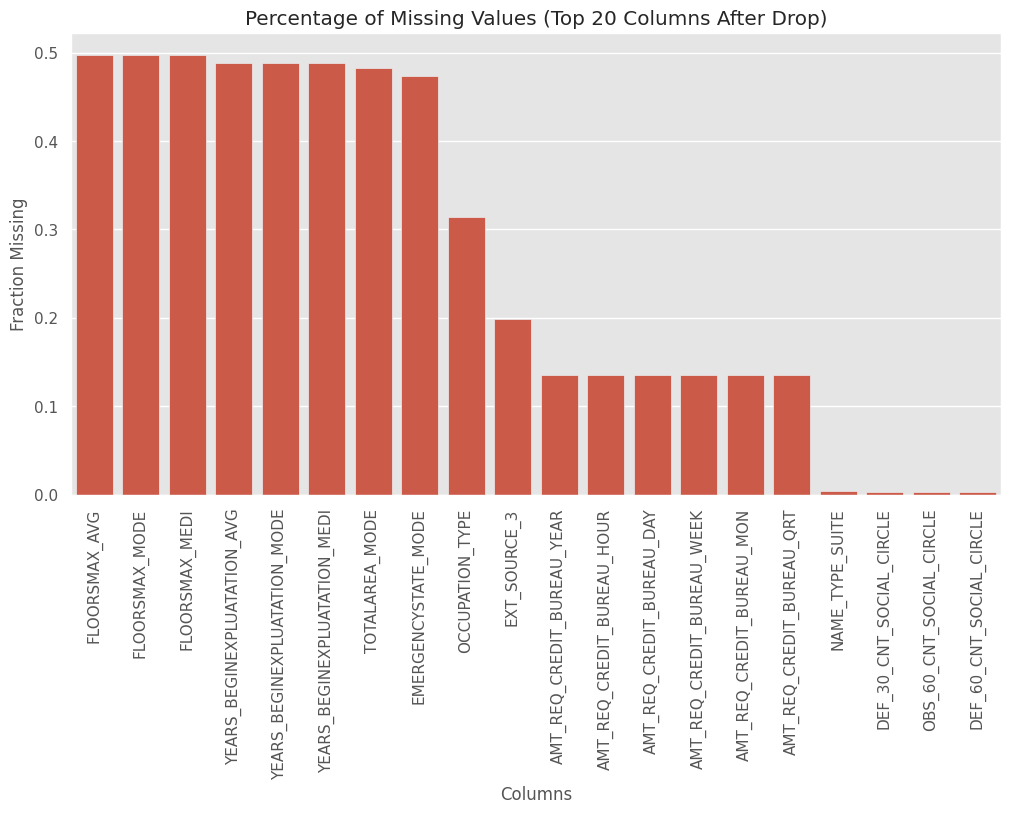

In [ ]:
# Check missing values and drop columns with > 50% missing
missing_values = application_data.isnull().mean().sort_values(ascending=False)
columns_to_drop = missing_values[missing_values > 0.5].index
print(f"Dropping columns: {list(columns_to_drop)} due to >50% missing values.")
application_data.drop(columns=columns_to_drop, axis=1, inplace=True)

# Visualize top 20 missing after dropping some columns
missing_values_after = application_data.isnull().mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values_after.index[:20], y=missing_values_after.values[:20])
plt.xticks(rotation=90)
plt.title("Percentage of Missing Values (Top 20 Columns After Drop)")
plt.ylabel("Fraction Missing")
plt.xlabel("Columns")
plt.show()

Handling missing values

In [ ]:
# Separate numeric and categorical columns
numeric_cols = application_data.select_dtypes(include=[np.number]).columns
cat_cols = application_data.select_dtypes(include=['object']).columns

# Impute numeric with median
num_missing = numeric_cols[application_data[numeric_cols].isnull().any()]
for col in num_missing:
    median_val = application_data[col].median()
    application_data[col].fillna(median_val, inplace=True)

# Impute categorical with mode
cat_missing = cat_cols[application_data[cat_cols].isnull().any()]
for col in cat_missing:
    mode_val = application_data[col].mode()[0]
    application_data[col].fillna(mode_val, inplace=True)

# Drop duplicates
duplicates = application_data.duplicated().sum()
if duplicates > 0:
    print(f"Dropping {duplicates} duplicate rows.")
    application_data.drop_duplicates(inplace=True)

Outliers treatment

In [ ]:
# Cap numeric features at 1% and 99% quantiles to reduce extreme outliers
lower_quantiles = application_data[numeric_cols].quantile(0.01)
upper_quantiles = application_data[numeric_cols].quantile(0.99)
for col in numeric_cols:
    application_data[col] = np.clip(application_data[col], lower_quantiles[col], upper_quantiles[col])

Correlation matrix

Shape of processed data: (307511, 181)


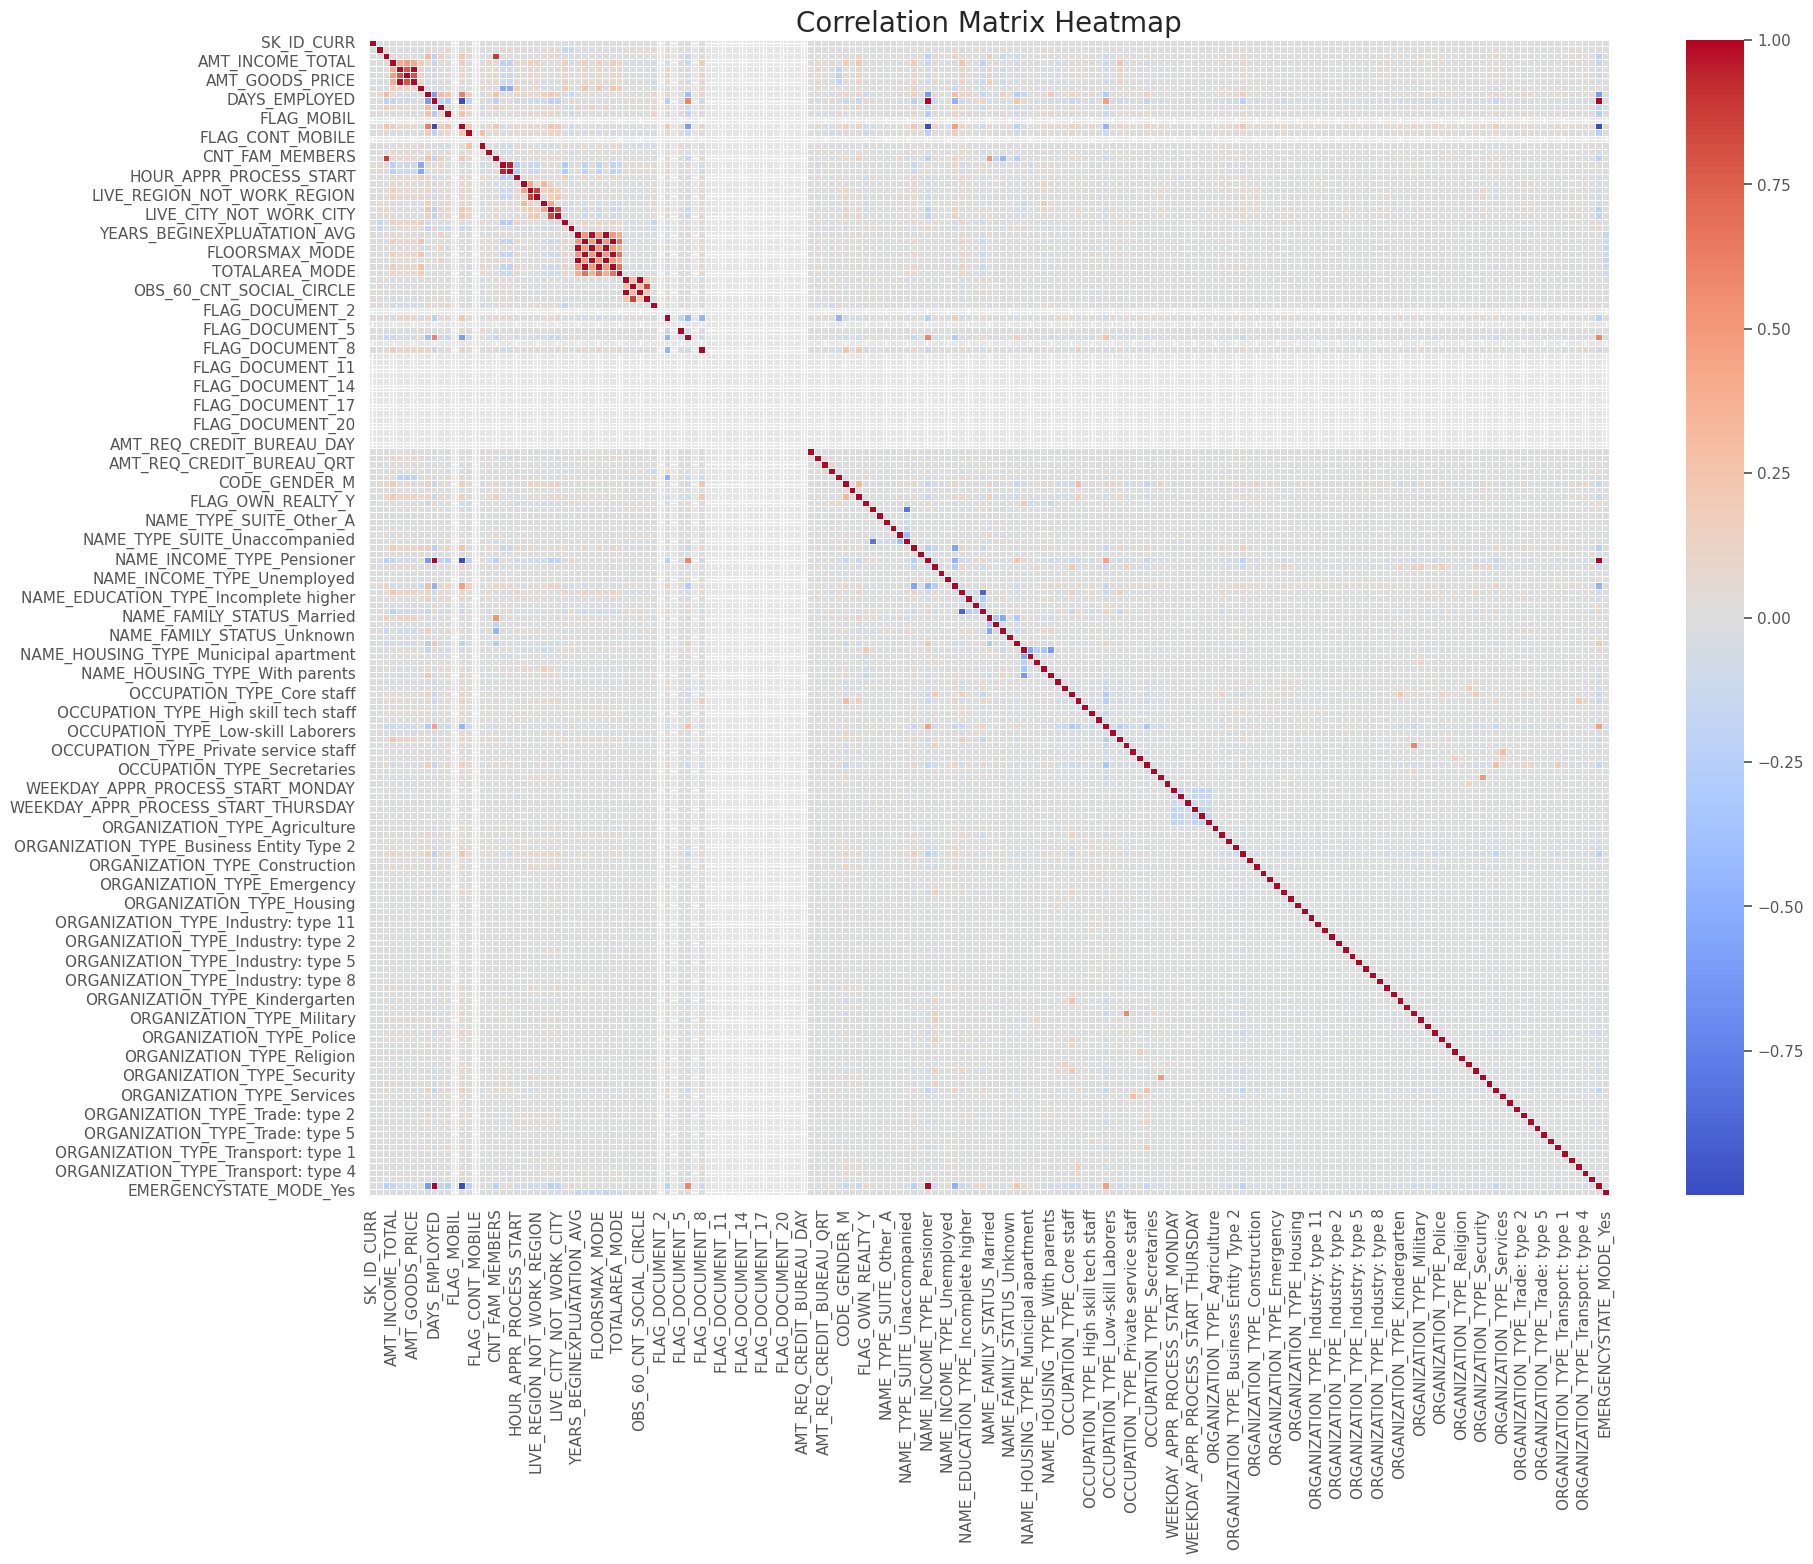

In [ ]:
application_data = pd.get_dummies(application_data, drop_first=True)
print(f"Shape of processed data: {application_data.shape}")

correlation_matrix = application_data.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap", fontsize=20)

plt.show()

Save cleaned data to a new file

In [ ]:
output_path = "/content/drive/MyDrive/CSE598ProjectFinance/initial_clean_data.csv"
application_data.to_csv(output_path, index=False)
print(f"Cleaned data saved to '{output_path}'")

Cleaned data saved to '/content/drive/MyDrive/CSE598ProjectFinance/initial_clean_data.csv'


##Data prep using Random Forest


Load in the data

In [ ]:
cleaned_data = pd.read_csv("/content/drive/MyDrive/CSE598ProjectFinance/initial_clean_data.csv")

print(cleaned_data.shape)
print(cleaned_data.value_counts())
print(cleaned_data['TARGET'].value_counts())

(307511, 181)
SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_2  EXT_SOURCE_3  YEARS_BEGINEXPLUATATION_AVG  FLOORSMAX_AVG  YEARS_BEGINEXPLUATATION_MODE  FLOORSMAX_MODE  YEARS_BEGINEXPLUATATION_MEDI  FLOORSMAX_MEDI  TOTALAREA_MODE  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  F

Separating features and target to further drop features using Random Forest

In [ ]:
X = cleaned_data.drop('TARGET', axis=1)
y = cleaned_data['TARGET']

# Remove low-variance features
var_thresh = 0.01
selector = VarianceThreshold(threshold=var_thresh)
X_reduced = selector.fit_transform(X)

# Get the columns that remain after variance threshold
remaining_features = X.columns[selector.get_support()]
X = pd.DataFrame(X_reduced, columns=remaining_features)

print(f"Remaining features after low-variance removal: {X.shape[1]}")

Remaining features after low-variance removal: 98


Random Forest model-based feature selection

In [ ]:
# Model-based Feature Selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances and select top 60 features
importances = rf.feature_importances_
feature_importances = pd.Series(importances, index=X.columns)
top_60_features = feature_importances.nlargest(60).index

X_final = X[top_60_features]

print("Top 60 Features Selected:")
print(top_60_features)

# Combine selected features with target for the final dataset
final_data = pd.concat([X_final, y], axis=1)

Top 60 Features Selected:
Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
       'DAYS_REGISTRATION', 'SK_ID_CURR', 'AMT_ANNUITY',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_EMPLOYED', 'AMT_CREDIT',
       'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'CNT_FAM_MEMBERS', 'FLOORSMAX_AVG',
       'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'CNT_CHILDREN', 'FLAG_OWN_REALTY_Y',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_MON',
       'FLAG_OWN_CAR_Y', 'NAME_FAMILY_STATUS_Married', 'FLAG_PHONE',
       'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT',
       'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'CODE_GENDER_M',
       'OCCUPATION_TYPE_Laborers', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
       'ORGANIZATION_TYPE_Business Entity Type 3', 'FLAG_WORK_PHONE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'WEEKDAY_APPR_PROCESS_START_THURSDAY',
       'WEEKDAY

Random Forest model-based correlation matrix

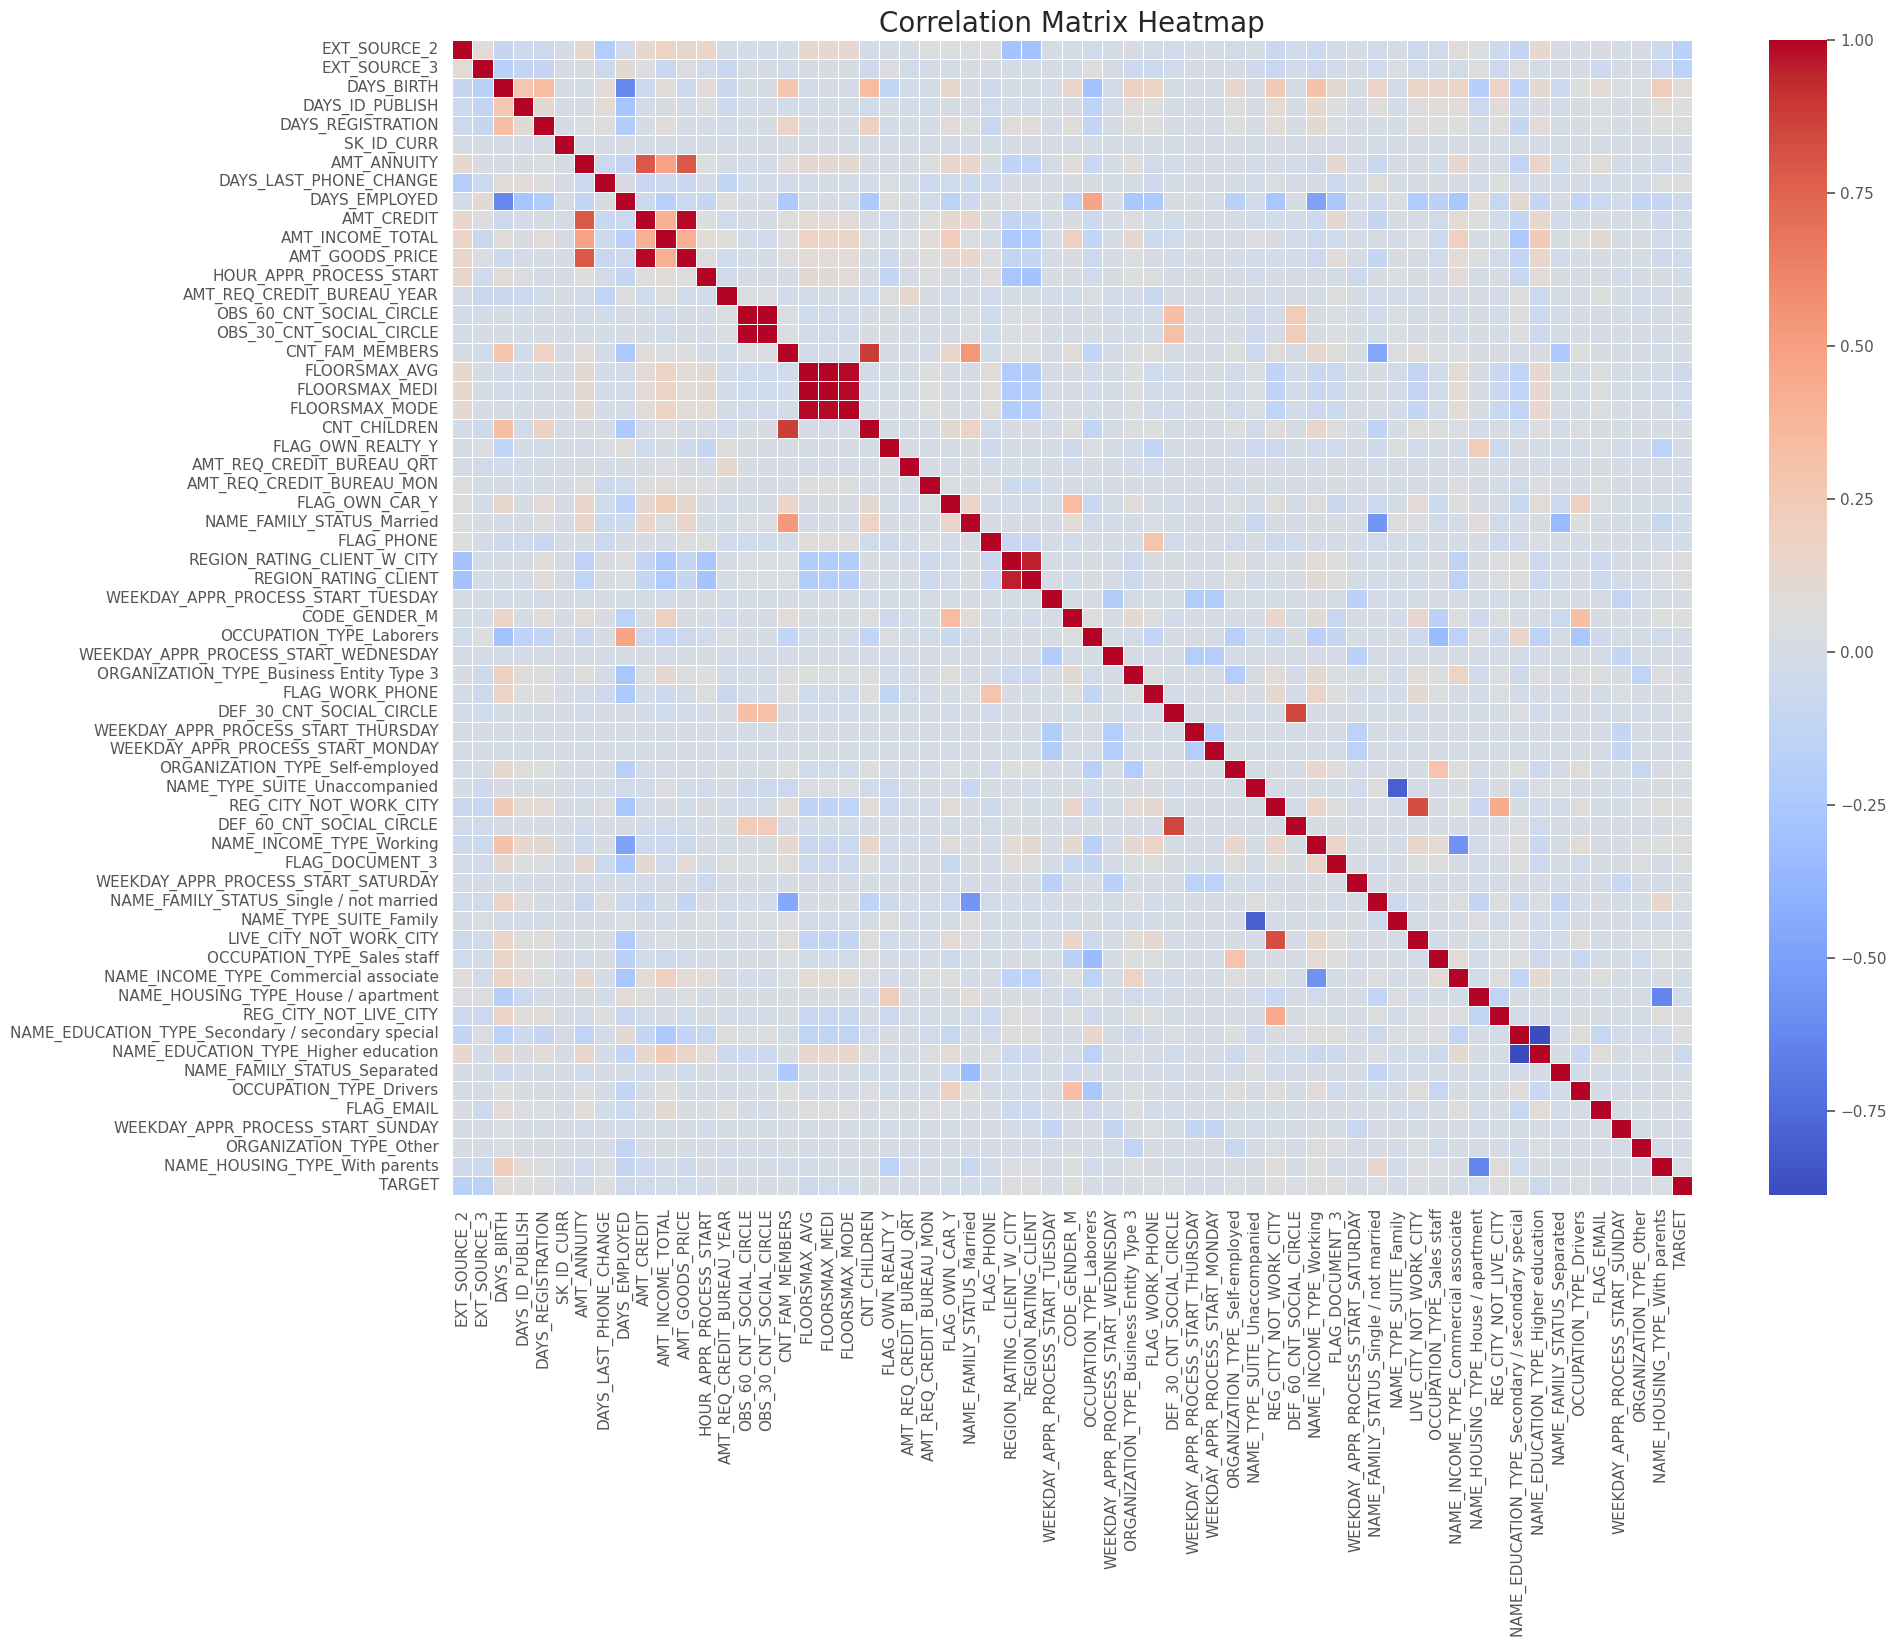

In [ ]:
correlation_matrix = final_data.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap", fontsize=20)

plt.show()

Save after cleaning the data more

In [ ]:
output_path = "/content/drive/MyDrive/CSE598ProjectFinance/second_clean_data.csv"
final_data.to_csv(output_path, index=False)
print(f"Reduced data with top 60 features saved to '{output_path}'")

Reduced data with top 60 features saved to '/content/drive/MyDrive/CSE598ProjectFinance/second_clean_data.csv'


##Dimensionality reduction using XGBoost/MutualInfoClassification + Bayesian Network Grid Search

Load in the data

In [ ]:
cleaned_data = pd.read_csv("/content/drive/MyDrive/CSE598ProjectFinance/second_clean_data.csv")

print(cleaned_data.shape)
print(cleaned_data.value_counts())
print(cleaned_data['TARGET'].value_counts())

(307511, 61)
EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  DAYS_ID_PUBLISH  DAYS_REGISTRATION  SK_ID_CURR  AMT_ANNUITY  DAYS_LAST_PHONE_CHANGE  DAYS_EMPLOYED  AMT_CREDIT  AMT_INCOME_TOTAL  AMT_GOODS_PRICE  HOUR_APPR_PROCESS_START  AMT_REQ_CREDIT_BUREAU_YEAR  OBS_60_CNT_SOCIAL_CIRCLE  OBS_30_CNT_SOCIAL_CIRCLE  CNT_FAM_MEMBERS  FLOORSMAX_AVG  FLOORSMAX_MEDI  FLOORSMAX_MODE  CNT_CHILDREN  FLAG_OWN_REALTY_Y  AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_MON  FLAG_OWN_CAR_Y  NAME_FAMILY_STATUS_Married  FLAG_PHONE  REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT  WEEKDAY_APPR_PROCESS_START_TUESDAY  CODE_GENDER_M  OCCUPATION_TYPE_Laborers  WEEKDAY_APPR_PROCESS_START_WEDNESDAY  ORGANIZATION_TYPE_Business Entity Type 3  FLAG_WORK_PHONE  DEF_30_CNT_SOCIAL_CIRCLE  WEEKDAY_APPR_PROCESS_START_THURSDAY  WEEKDAY_APPR_PROCESS_START_MONDAY  ORGANIZATION_TYPE_Self-employed  NAME_TYPE_SUITE_Unaccompanied  REG_CITY_NOT_WORK_CITY  DEF_60_CNT_SOCIAL_CIRCLE  NAME_INCOME_TYPE_Working  FLAG_DOCUMENT_3  WEEKDAY_

Splitting between features and target for the XGBoost model feature reduction

In [ ]:
if 'TARGET' not in cleaned_data.columns:
    raise ValueError("The dataset must contain a 'TARGET' column.")

data = cleaned_data.copy()
X = data.drop('TARGET', axis=1)
y = data['TARGET']

Handling class imbalance

In [ ]:
minority_class = (y == 1)
majority_class = (y == 0)

X_minority = X[minority_class]
y_minority = y[minority_class]

X_majority = X[majority_class]
y_majority = y[majority_class]

minority_count = y_minority.shape[0]
majority_needed = minority_count + 5000
if majority_needed > len(y_majority):
    majority_needed = len(y_majority)

X_majority_sampled = X_majority.sample(n=majority_needed, random_state=42)
y_majority_sampled = y_majority.loc[X_majority_sampled.index]

X_balanced = pd.concat([X_minority, X_majority_sampled], axis=0)
y_balanced = pd.concat([y_minority, y_majority_sampled], axis=0)

Feature Selection (MI + XGBoost)

In [ ]:
mi_scores = mutual_info_classif(X_balanced, y_balanced, discrete_features=False)
mi_series = pd.Series(mi_scores, index=X_balanced.columns).sort_values(ascending=False)

top_mi_features = mi_series.head(30).index
X_mi = X_balanced[top_mi_features]

xgb = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, random_state=42, tree_method='hist')
xgb.fit(X_mi, y_balanced)
xgb_importances = pd.Series(xgb.feature_importances_, index=X_mi.columns).sort_values(ascending=False)

final_features = xgb_importances.head(30).index

X_final = X_mi[final_features]
y_final = y_balanced

Correlation matrix

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

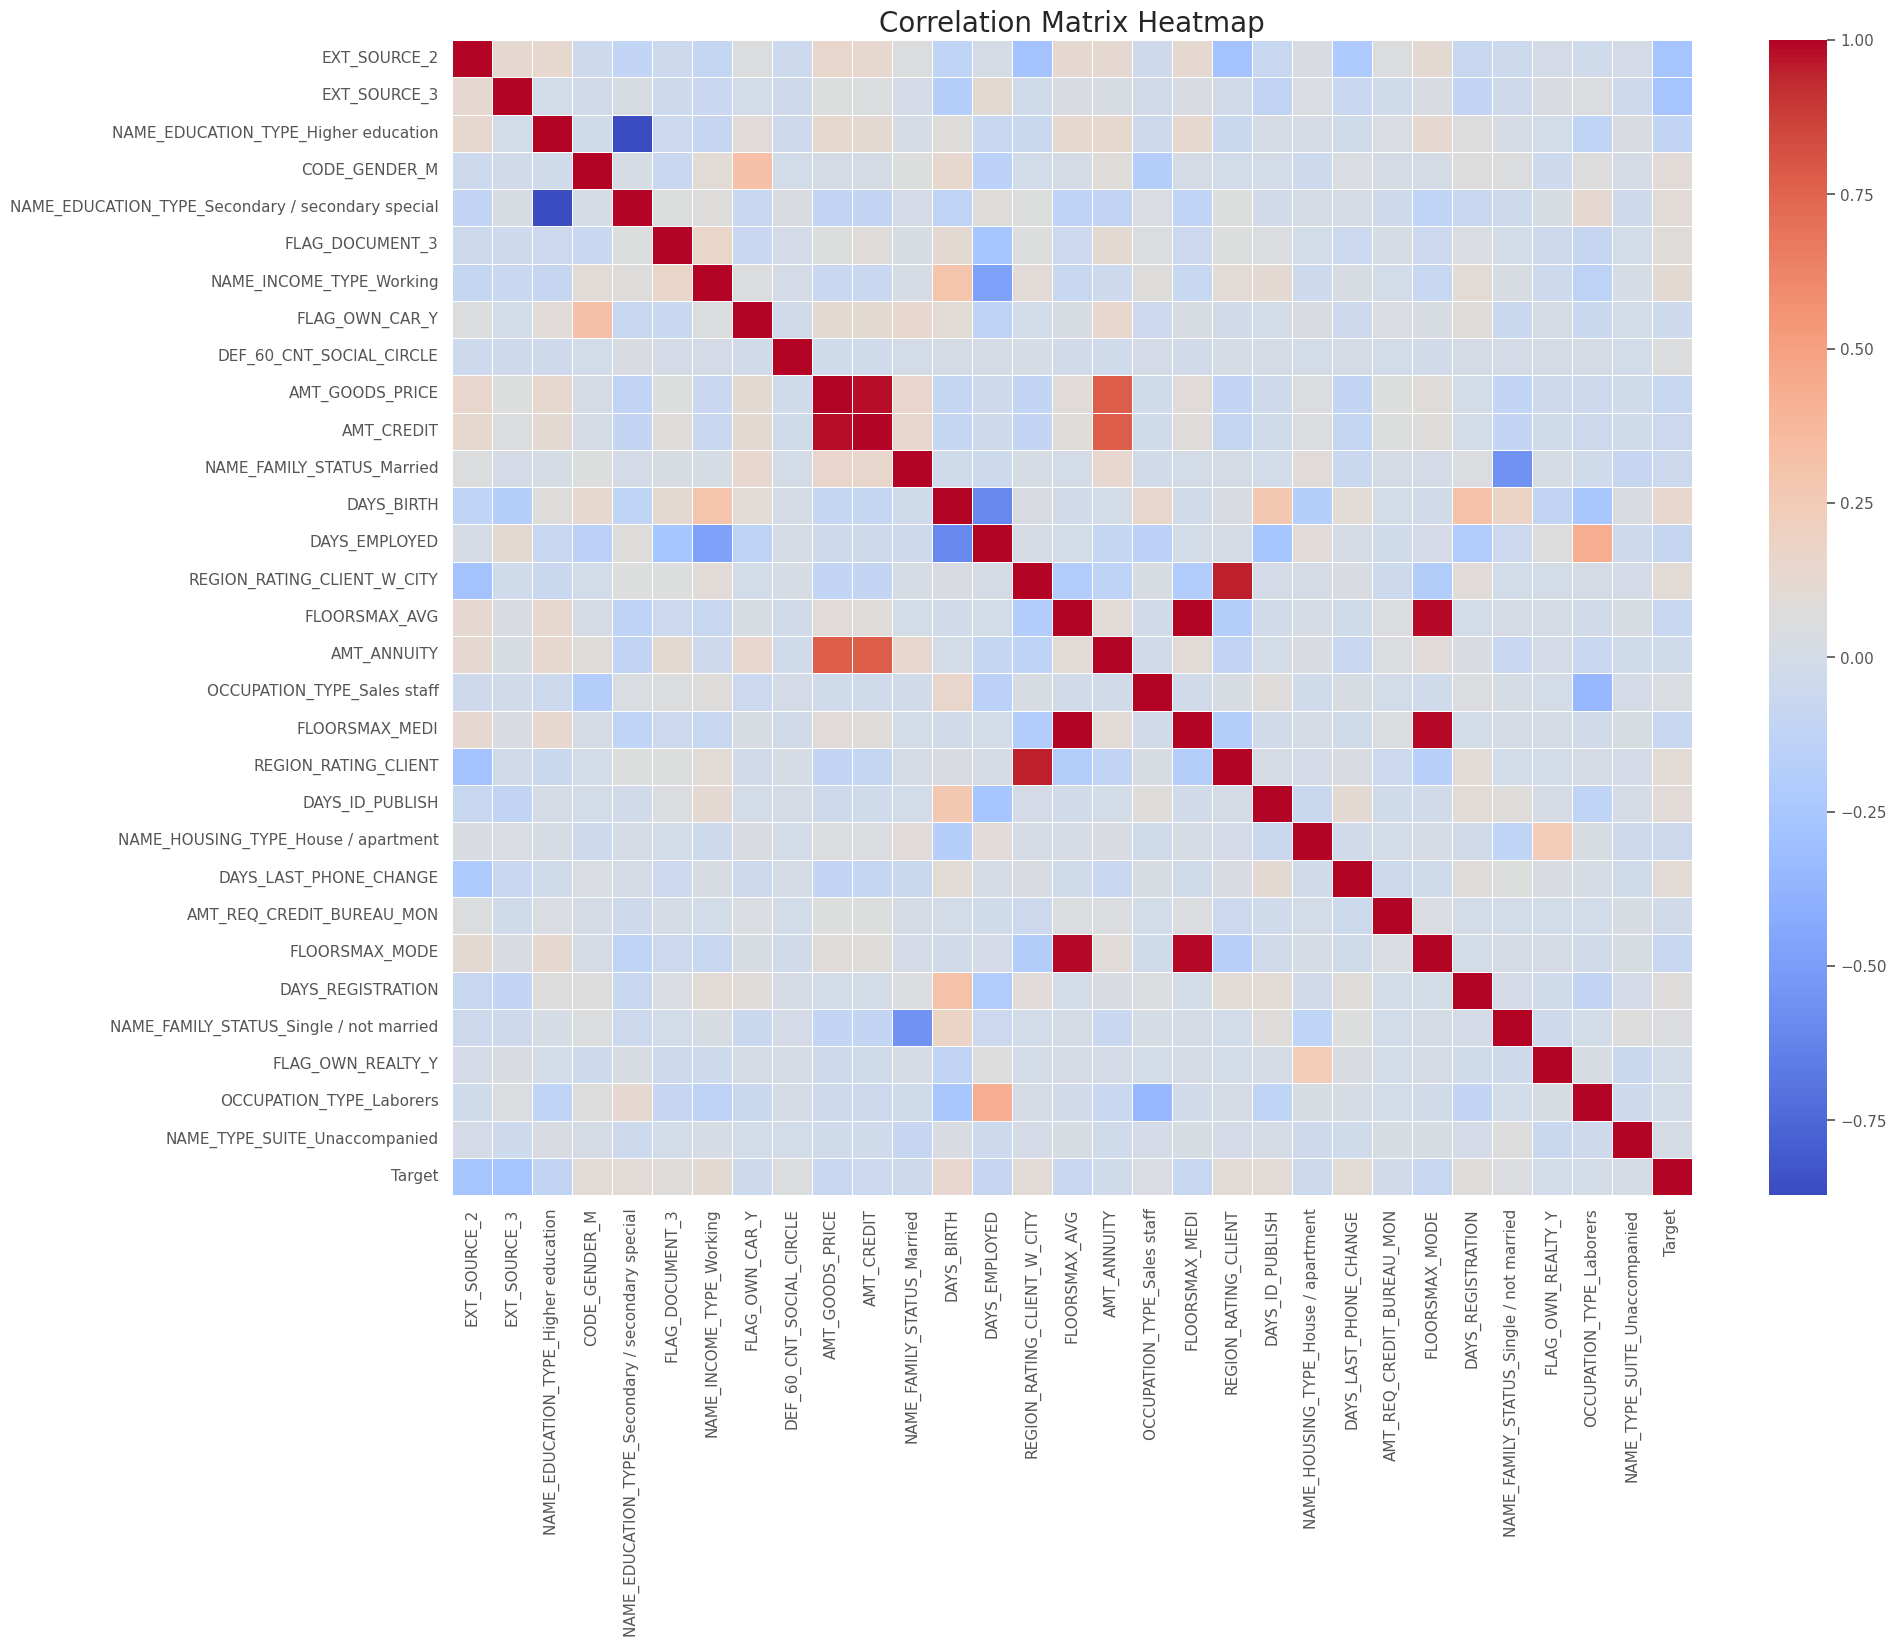

In [ ]:
data_combined = pd.concat([X_final, y_final.rename('Target')], axis=1)

correlation_matrix = data_combined.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap", fontsize=20)

Additional Insights of the data

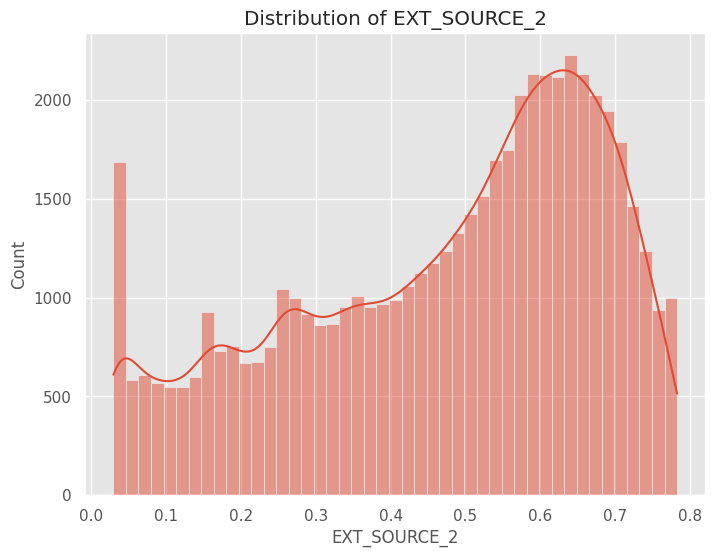

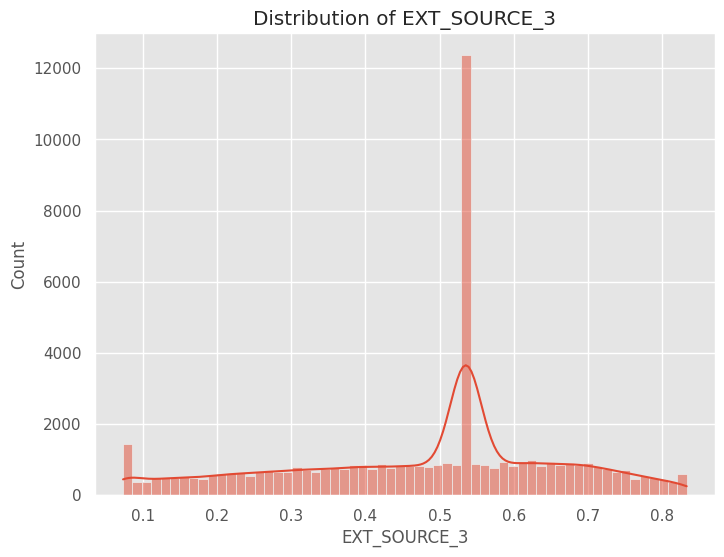

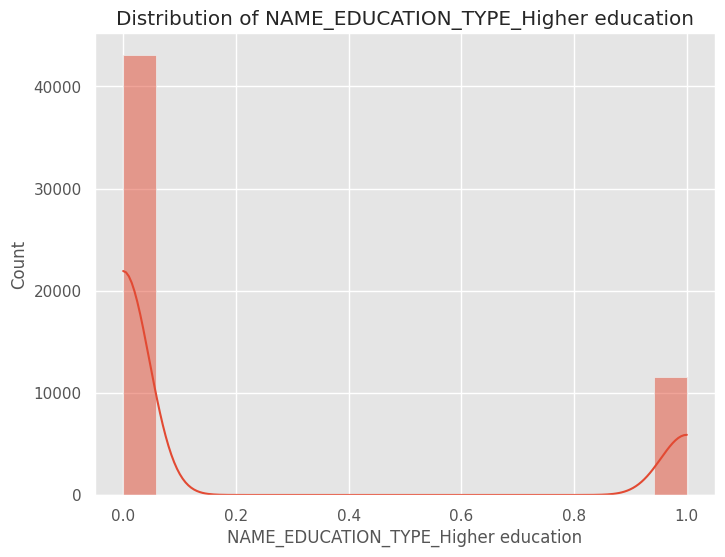

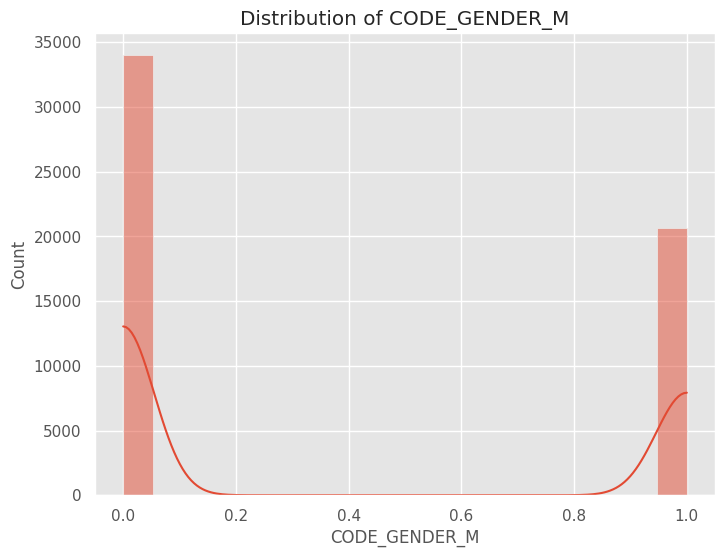

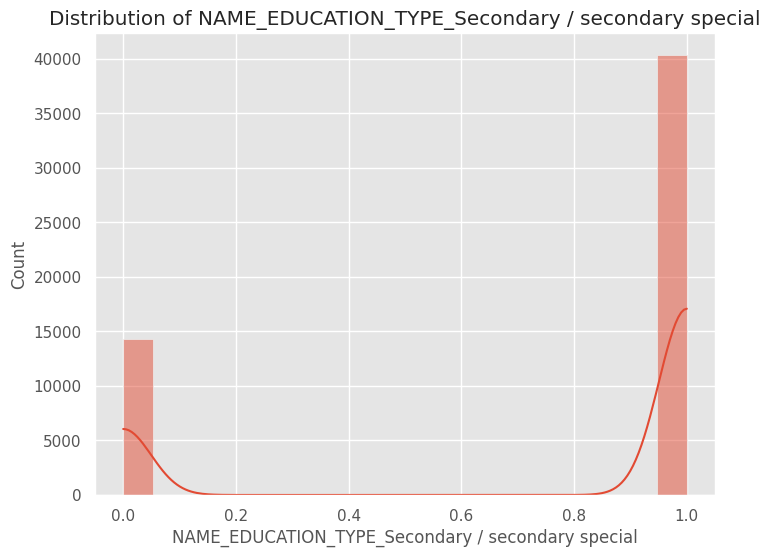

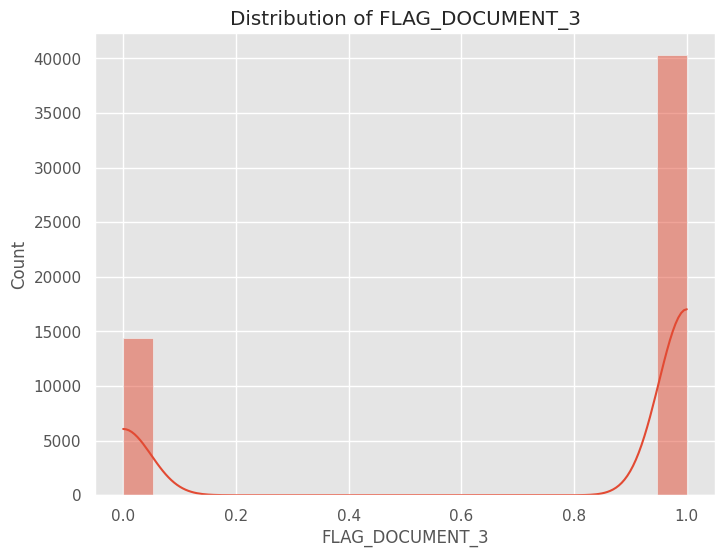

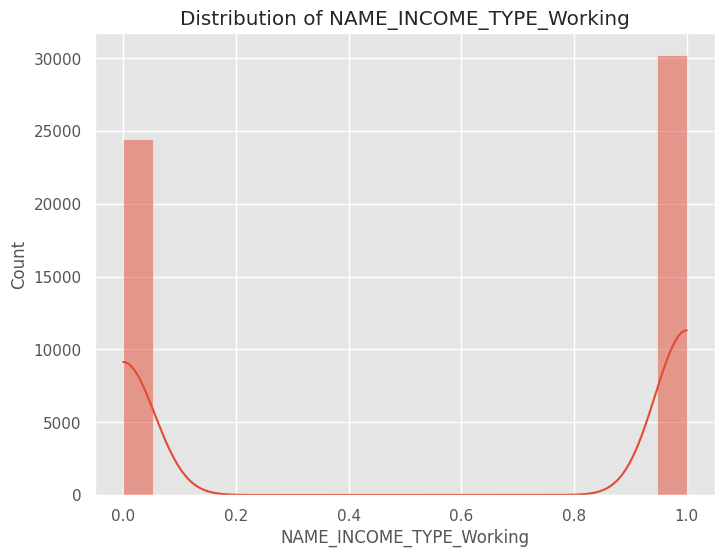

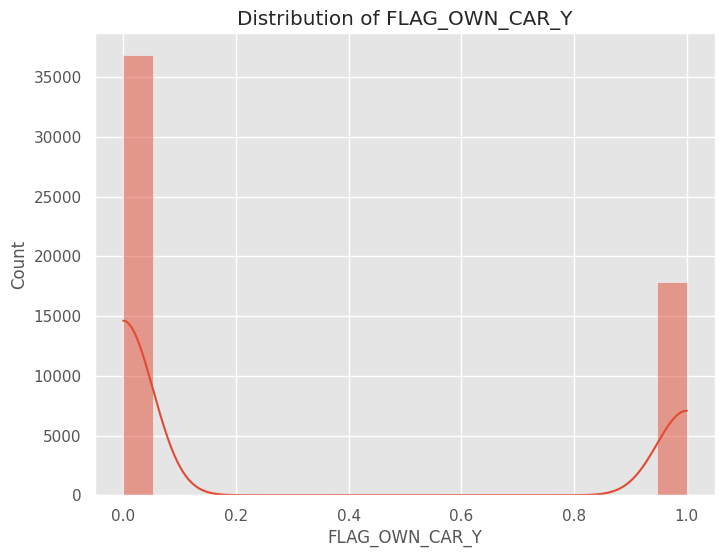

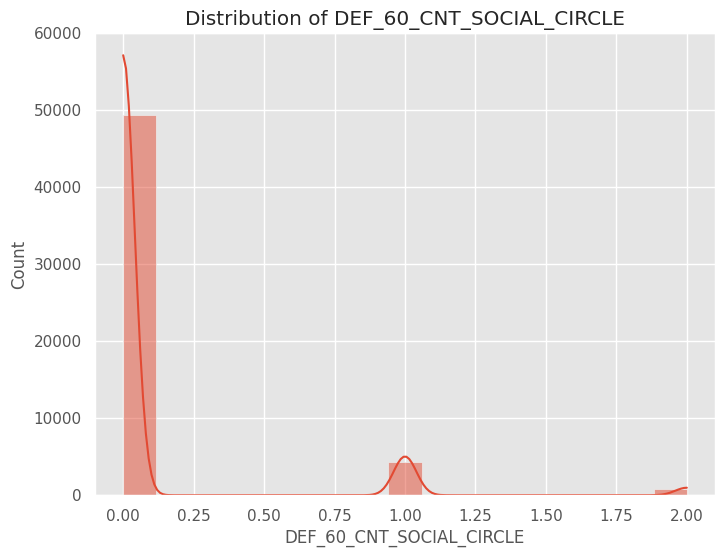

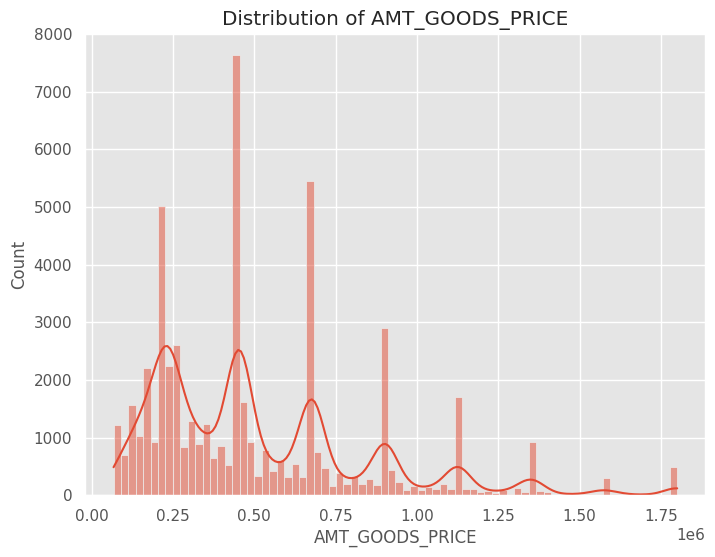

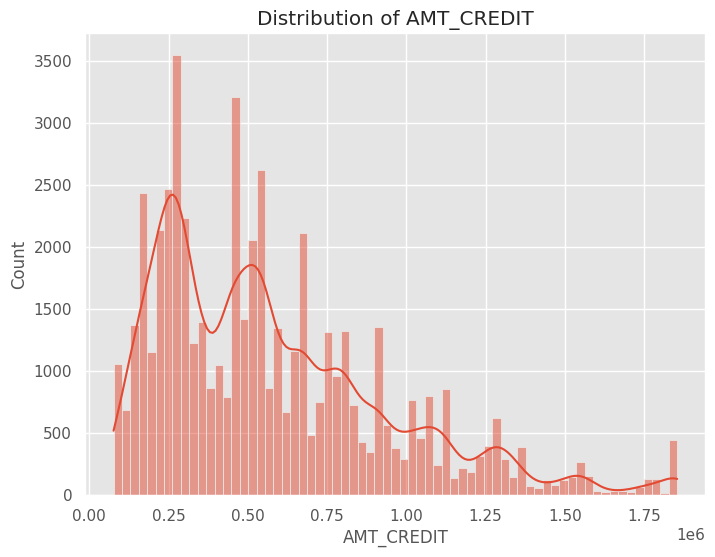

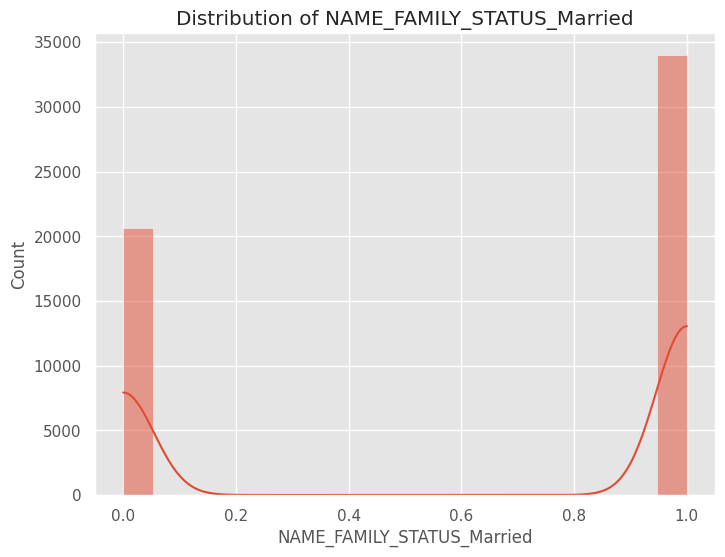

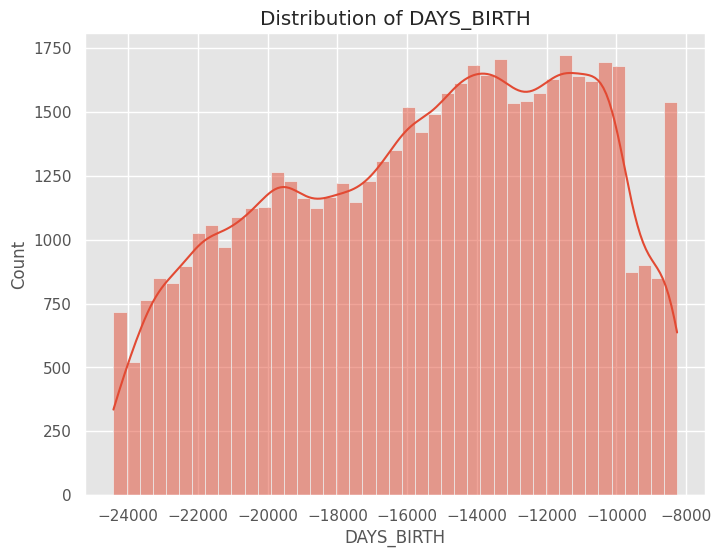

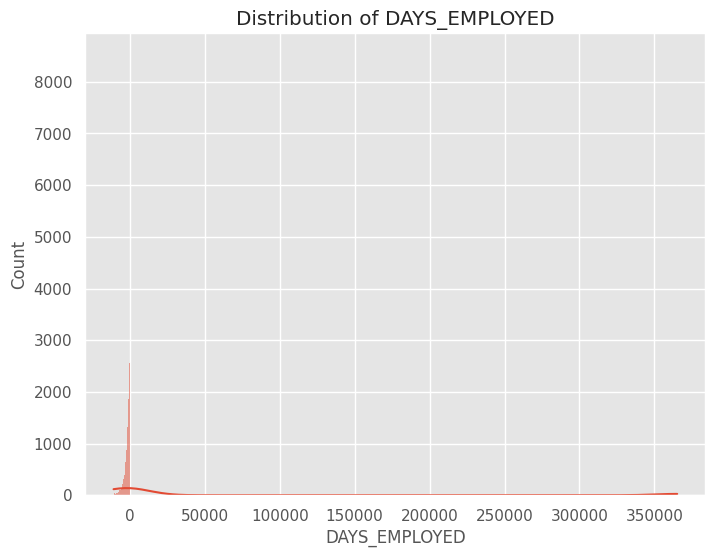

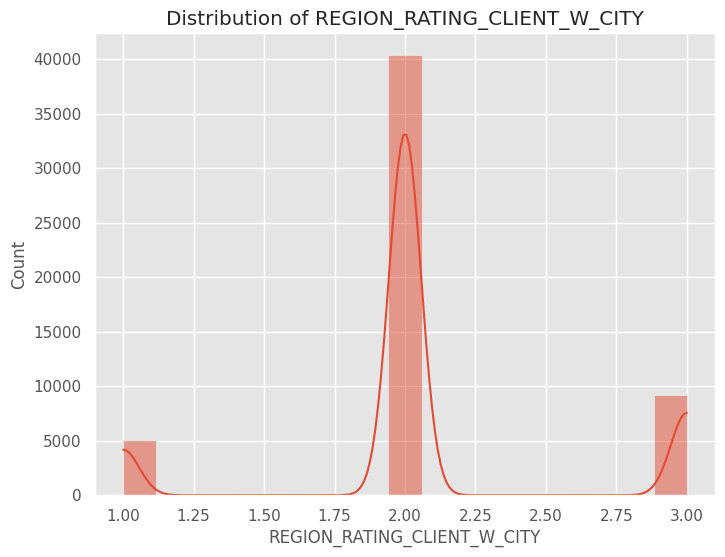

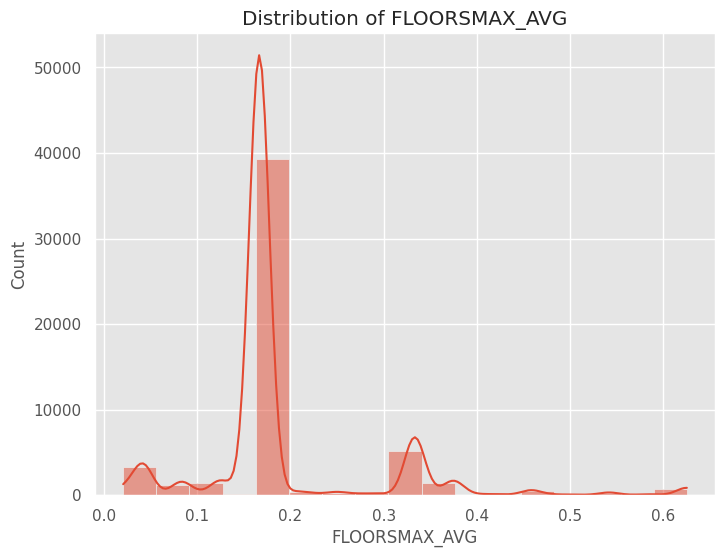

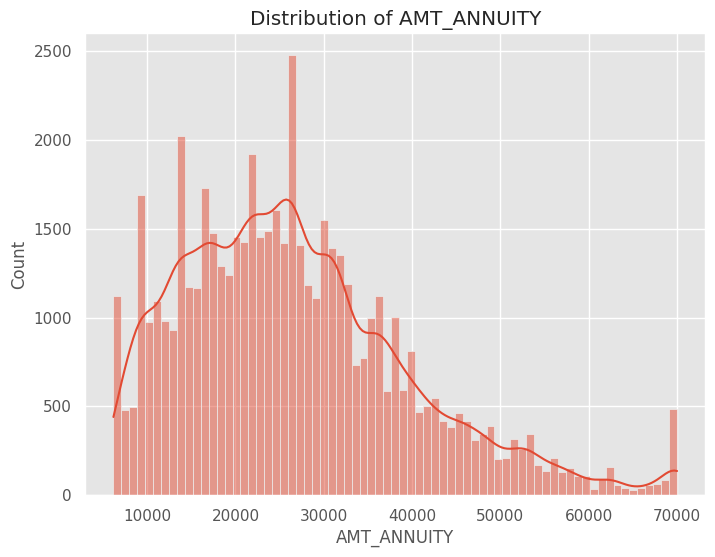

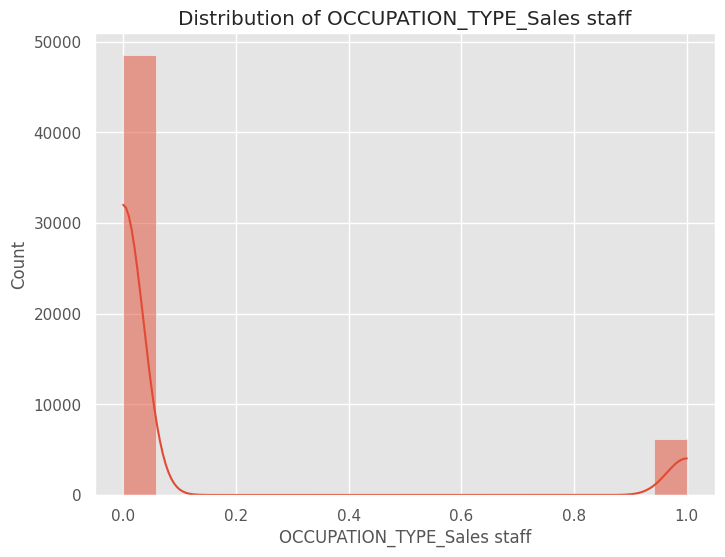

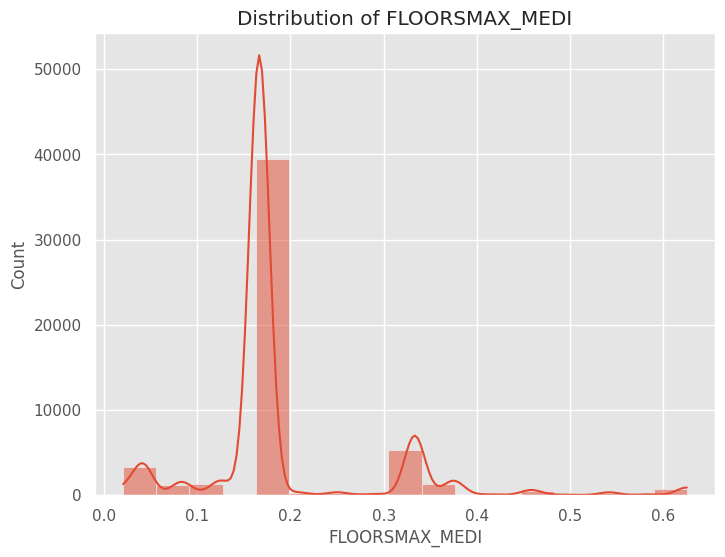

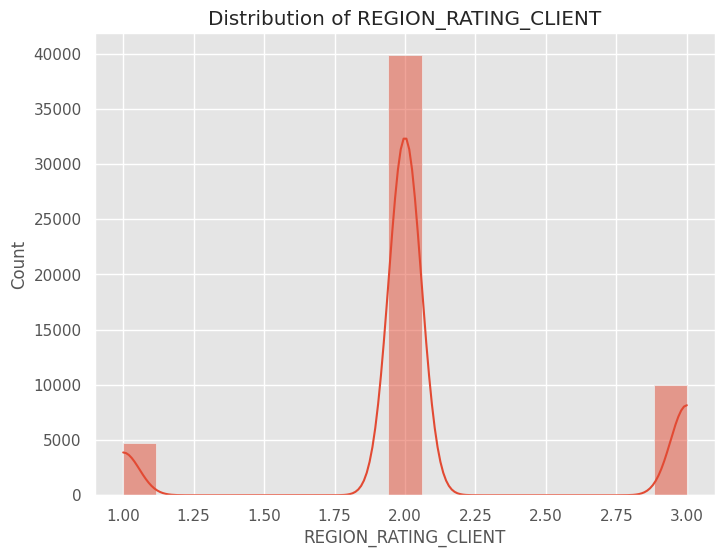

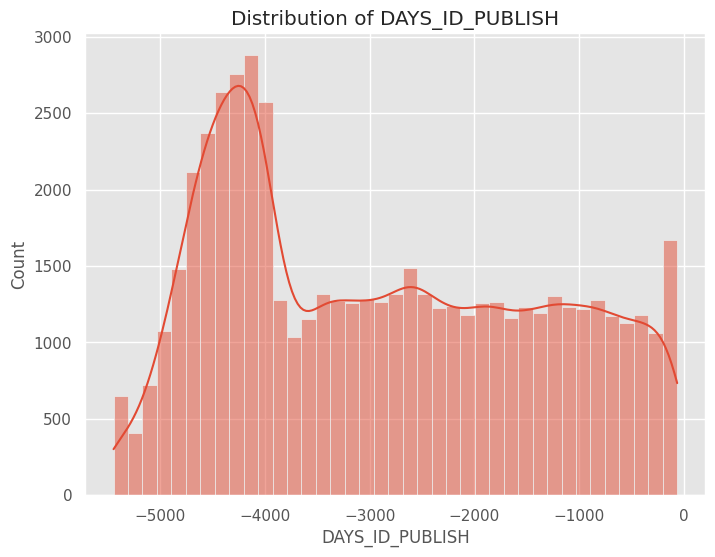

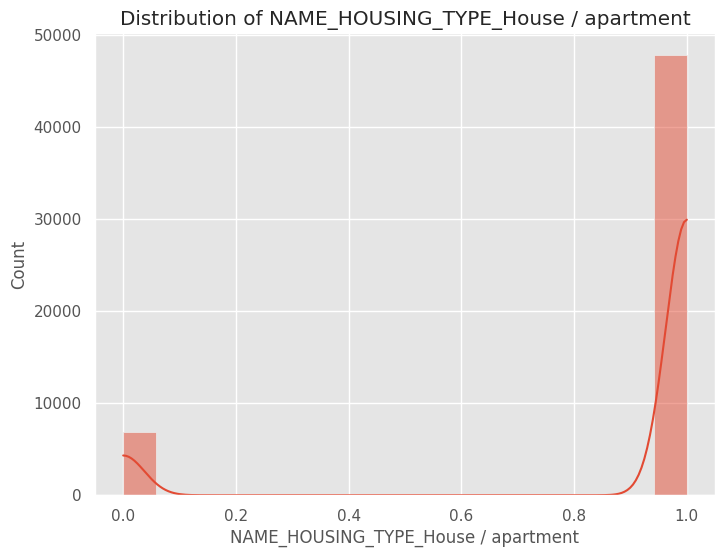

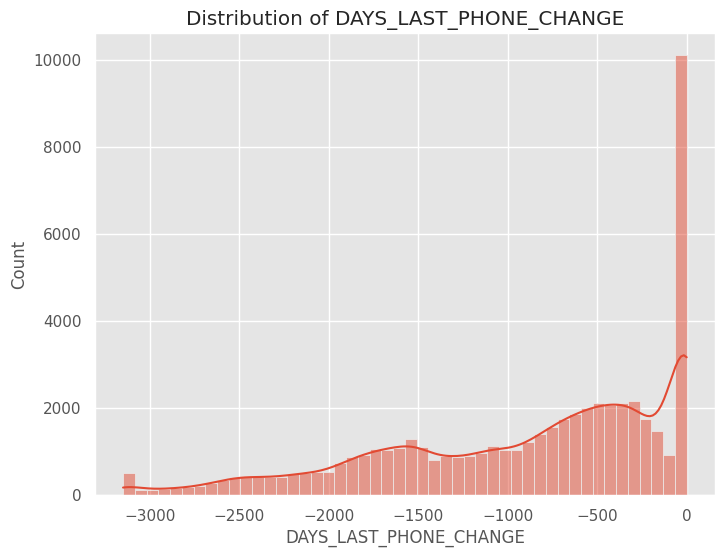

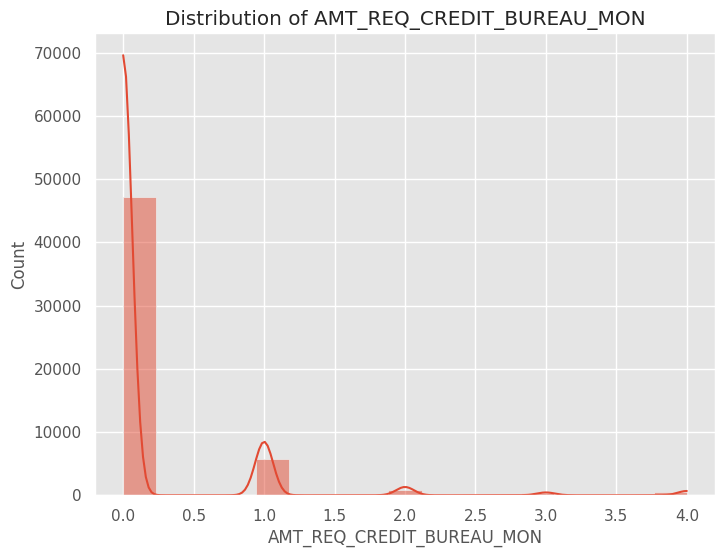

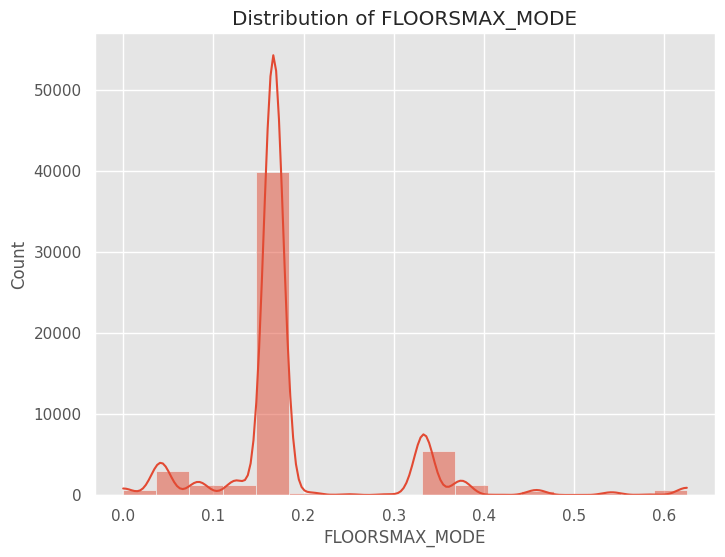

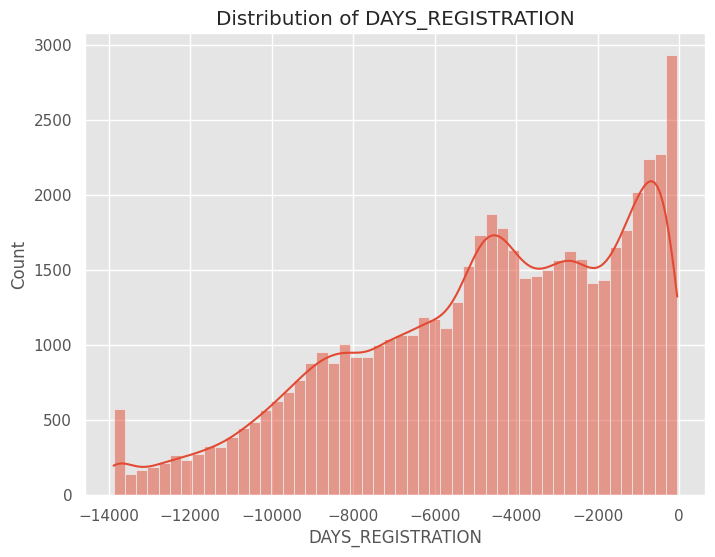

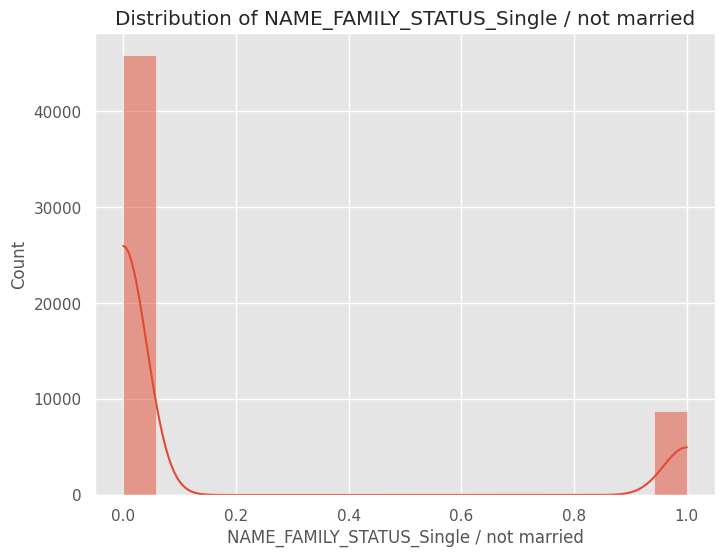

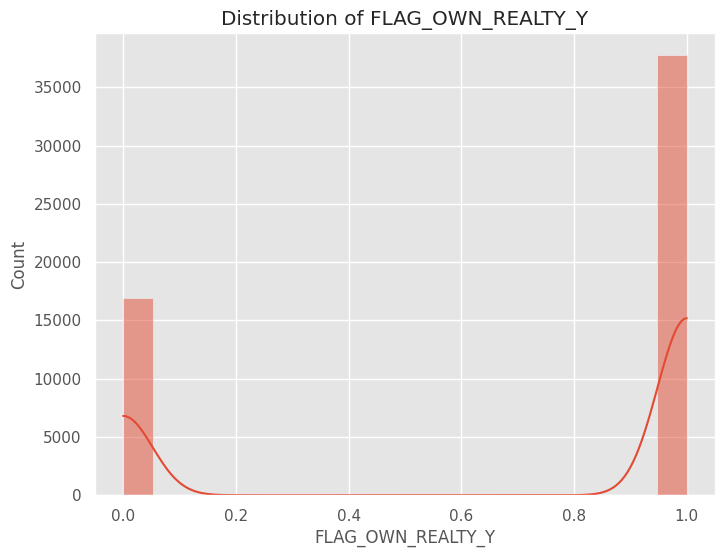

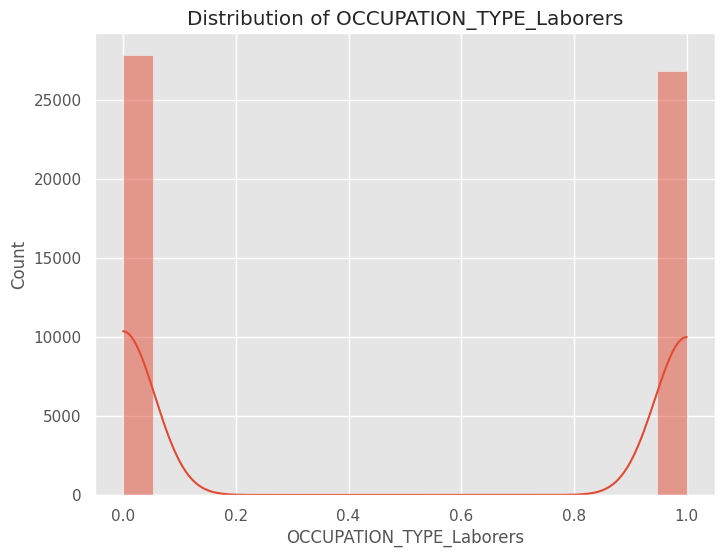

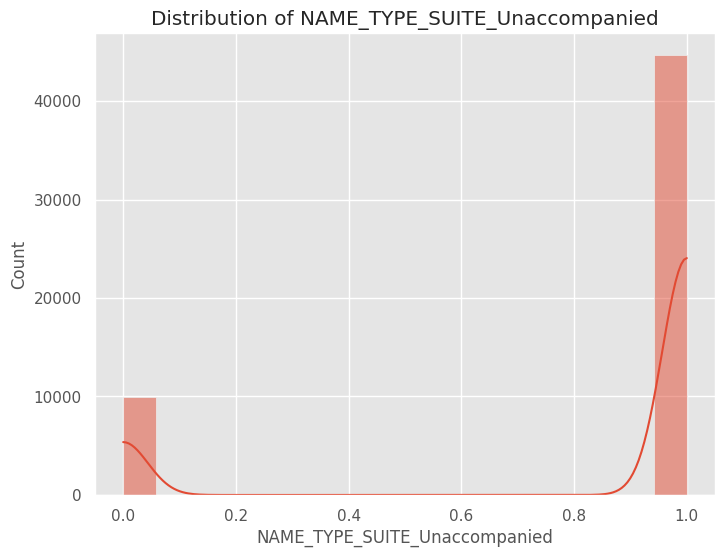

In [ ]:
for col in final_features[:len(final_features)]:
    plt.figure(figsize=(8, 6))
    sns.histplot(data_combined[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

Plot of data distribution

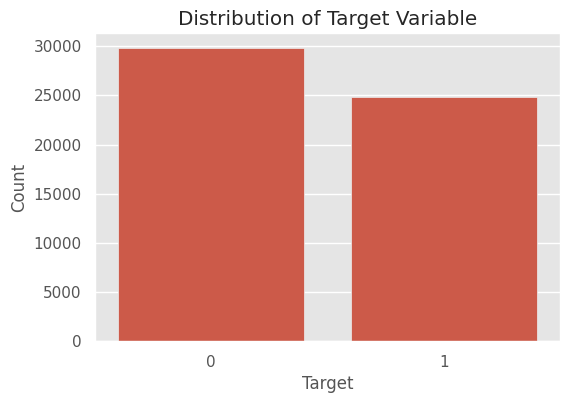

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=data_combined)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

Manual Grid Search for the Bayesian Network

In [ ]:
bin_options = [2, 3, 4]
scoring_methods = [BDeuScore, K2Score, BicScore]
equivalent_sample_sizes = [5, 10]

results = []

for bins in bin_options:
    discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile')
    X_discretized = discretizer.fit_transform(X_final)

    X_train, X_test, y_train, y_test = train_test_split(
        X_discretized, y_final, test_size=0.2, random_state=42, stratify=y_final
    )
    train_data = pd.DataFrame(X_train, columns=final_features)
    train_data['TARGET'] = y_train.values

    for score_method in scoring_methods:
        for ess in equivalent_sample_sizes:
            # Conditional initialization based on scoring method
            if score_method == BDeuScore:
                scoring = score_method(train_data, equivalent_sample_size=ess)
            else:  # For K2Score and BicScore
                scoring = score_method(train_data)
            hc = HillClimbSearch(train_data)
            best_model_structure = hc.estimate(scoring_method=scoring)

            model = BayesianNetwork(best_model_structure.edges())
            model.fit(train_data, estimator=MaximumLikelihoodEstimator)

            inference = VariableElimination(model)
            y_prob = []
            model_nodes = set(model.nodes())
            for i in range(X_test.shape[0]):
                evidence = {final_features[j]: X_test[i][j] for j in range(len(final_features)) if final_features[j] in model_nodes}
                try:
                    q = inference.query(variables=['TARGET'], evidence=evidence)
                    y_prob.append(q.values[1])
                except ValueError as e:
                    print(f"Error querying Bayesian Network: {e}")
                    # Instead of assigning 0.5, impute with the mean/median
                    y_prob.append(np.nan)

            # Impute NaNs in y_prob with the mean/median of the predicted probabilities
            y_prob = np.array(y_prob)
            y_prob[np.isnan(y_prob)] = np.nanmean(y_prob)

            auc_score = roc_auc_score(y_test, y_prob)
            y_pred = (np.array(y_prob) >= 0.5).astype(int)
            f1 = f1_score(y_test, y_pred)

            results.append({
                'bins': bins,
                'scoring_method': score_method.__name__,
                'equivalent_sample_size': ess,
                'roc_auc': auc_score,
                'f1_score': f1
            })

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Display results of the manual grid search

In [ ]:
results_df = pd.DataFrame(results)
best_model = results_df.loc[results_df['roc_auc'].idxmax()]

print("Best Model Configuration:")
print(best_model)

print("All Results:")
print(results_df.sort_values(by='roc_auc', ascending=False))

Best Model Configuration:
bins                              4
scoring_method            BDeuScore
equivalent_sample_size           10
roc_auc                    0.719192
f1_score                   0.622088
Name: 13, dtype: object
All Results:
    bins scoring_method  equivalent_sample_size   roc_auc  f1_score
13     4      BDeuScore                      10  0.719192  0.622088
15     4        K2Score                      10  0.715284  0.619359
14     4        K2Score                       5  0.715284  0.619359
17     4       BicScore                      10  0.714134  0.616931
16     4       BicScore                       5  0.714134  0.616931
12     4      BDeuScore                       5  0.713738  0.613012
6      3      BDeuScore                       5  0.705224  0.590581
8      3        K2Score                       5  0.704186  0.589973
9      3        K2Score                      10  0.704186  0.589973
7      3      BDeuScore                      10  0.703962  0.594917
10     3 

##Final Bayesian Network and Results

In [ ]:
# Hardcoded parameters
bins = 4
scoring_method = BDeuScore
equivalent_sample_size = 10

discretizer = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile')
X_discretized = discretizer.fit_transform(X_final)

X_train, X_test, y_train, y_test = train_test_split(
    X_discretized, y_final, test_size=0.2, random_state=42, stratify=y_final
)

train_data = pd.DataFrame(X_train, columns=final_features)
train_data['TARGET'] = y_train.values

# Use hardcoded scoring method and equivalent sample size
scoring = scoring_method(train_data)
hc = HillClimbSearch(train_data)
best_model_structure = hc.estimate(scoring_method=scoring)

model = BayesianNetwork(best_model_structure.edges())
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

inference = VariableElimination(model)

# Predict probabilities
model_nodes = set(model.nodes())
y_prob = []
for i in range(X_test.shape[0]):
    evidence = {final_features[j]: X_test[i][j] for j in range(len(final_features)) if final_features[j] in model_nodes}
    try:
        q = inference.query(variables=['TARGET'], evidence=evidence)
        y_prob.append(q.values[1])
    except ValueError:
        y_prob.append(np.nan)  # Temporarily assign NaN

# Impute NaNs in y_prob with the mean/median of the predicted probabilities
y_prob = np.array(y_prob)
y_prob[np.isnan(y_prob)] = np.nanmean(y_prob)

# Evaluate model
auc_score = roc_auc_score(y_test, y_prob)
y_pred = (y_prob >= 0.5).astype(int)
f1 = f1_score(y_test, y_pred)

print("ROC AUC Score:", auc_score)
print("F1 Score:", f1)

  0%|          | 0/1000000 [00:00<?, ?it/s]

ROC AUC Score: 0.7191921320154746
F1 Score: 0.6220881863560732


Edges

In [ ]:
for i in model.edges():
    print(i)

('EXT_SOURCE_2', 'TARGET')
('TARGET', 'EXT_SOURCE_3')
('TARGET', 'DAYS_BIRTH')
('TARGET', 'DAYS_EMPLOYED')
('TARGET', 'AMT_GOODS_PRICE')
('TARGET', 'AMT_CREDIT')
('TARGET', 'REGION_RATING_CLIENT_W_CITY')
('TARGET', 'FLOORSMAX_MODE')
('AMT_GOODS_PRICE', 'AMT_CREDIT')
('DAYS_BIRTH', 'DAYS_ID_PUBLISH')
('DAYS_BIRTH', 'DAYS_REGISTRATION')
('DAYS_BIRTH', 'AMT_GOODS_PRICE')
('DAYS_BIRTH', 'EXT_SOURCE_3')
('DAYS_ID_PUBLISH', 'DAYS_REGISTRATION')
('DAYS_EMPLOYED', 'DAYS_BIRTH')
('DAYS_EMPLOYED', 'DAYS_ID_PUBLISH')
('DAYS_EMPLOYED', 'AMT_ANNUITY')
('AMT_ANNUITY', 'AMT_GOODS_PRICE')
('AMT_ANNUITY', 'AMT_CREDIT')
('REGION_RATING_CLIENT_W_CITY', 'AMT_ANNUITY')
('REGION_RATING_CLIENT_W_CITY', 'FLOORSMAX_AVG')
('REGION_RATING_CLIENT_W_CITY', 'FLOORSMAX_MEDI')
('FLOORSMAX_MEDI', 'FLOORSMAX_AVG')
('REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY')
('REGION_RATING_CLIENT', 'EXT_SOURCE_2')
('REGION_RATING_CLIENT', 'DAYS_REGISTRATION')
('REGION_RATING_CLIENT', 'FLOORSMAX_AVG')
('REGION_RATING_CLIENT'

Results

Classification Report:
              precision    recall  f1-score   support

           0     0.6856    0.7217    0.7032      5965
           1     0.6431    0.6024    0.6221      4965

    accuracy                         0.6675     10930
   macro avg     0.6644    0.6621    0.6626     10930
weighted avg     0.6663    0.6675    0.6664     10930

Confusion Matrix:
[[4305 1660]
 [1974 2991]]


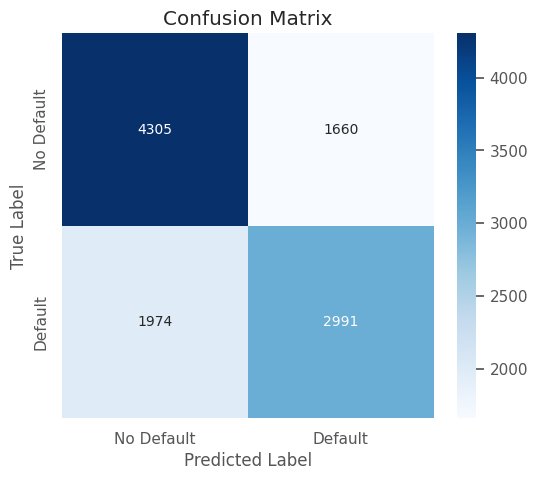

Precision-Recall AUC: 0.6655


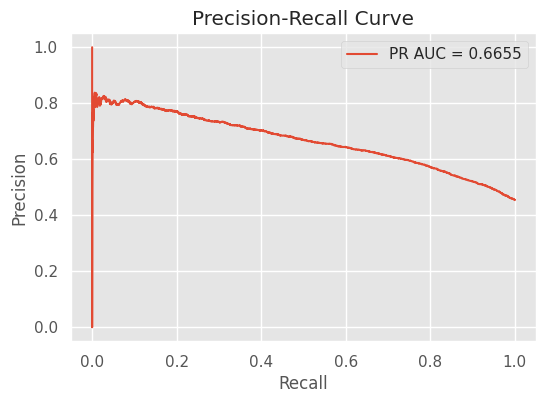

Brier Score: 0.2128


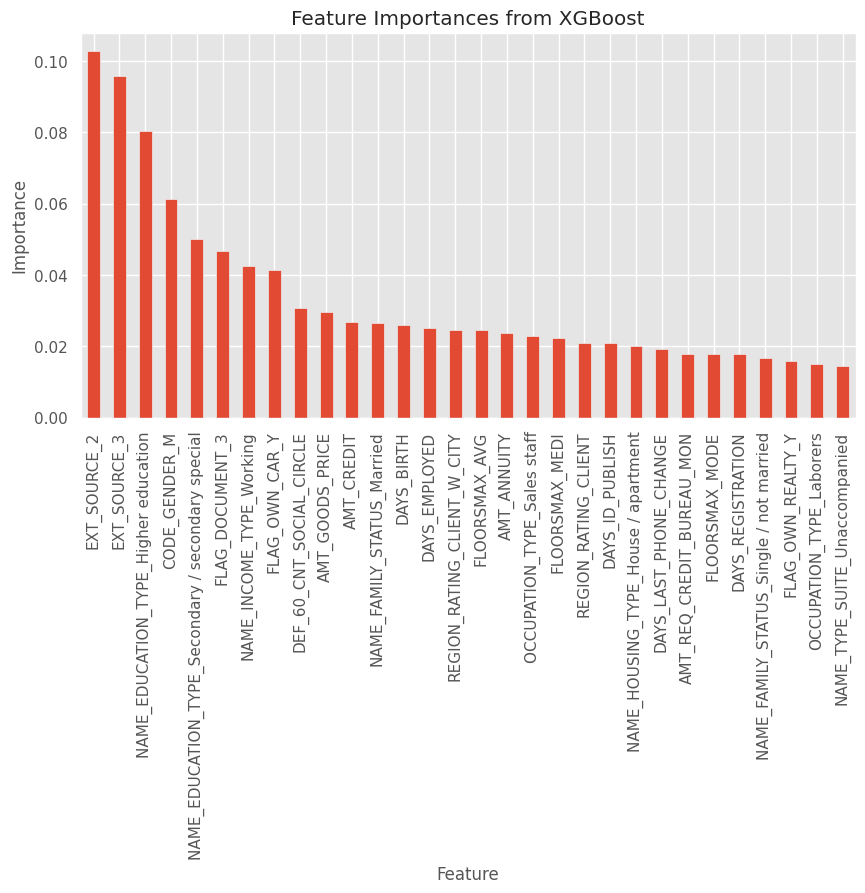

In [ ]:
threshold = 0.5
y_pred = (np.array(y_prob) >= threshold).astype(int)

# 1. Classification Report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'], )
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 3. Precision-Recall and PR-AUC
pr_auc = average_precision_score(y_test, y_prob)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 4. Brier Score
brier = brier_score_loss(y_test, y_prob)
print(f"Brier Score: {brier:.4f}")

# 5. XGBoost feature importance
xgb_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5))
plt.title("Feature Importances from XGBoost")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Final Bayesian Network

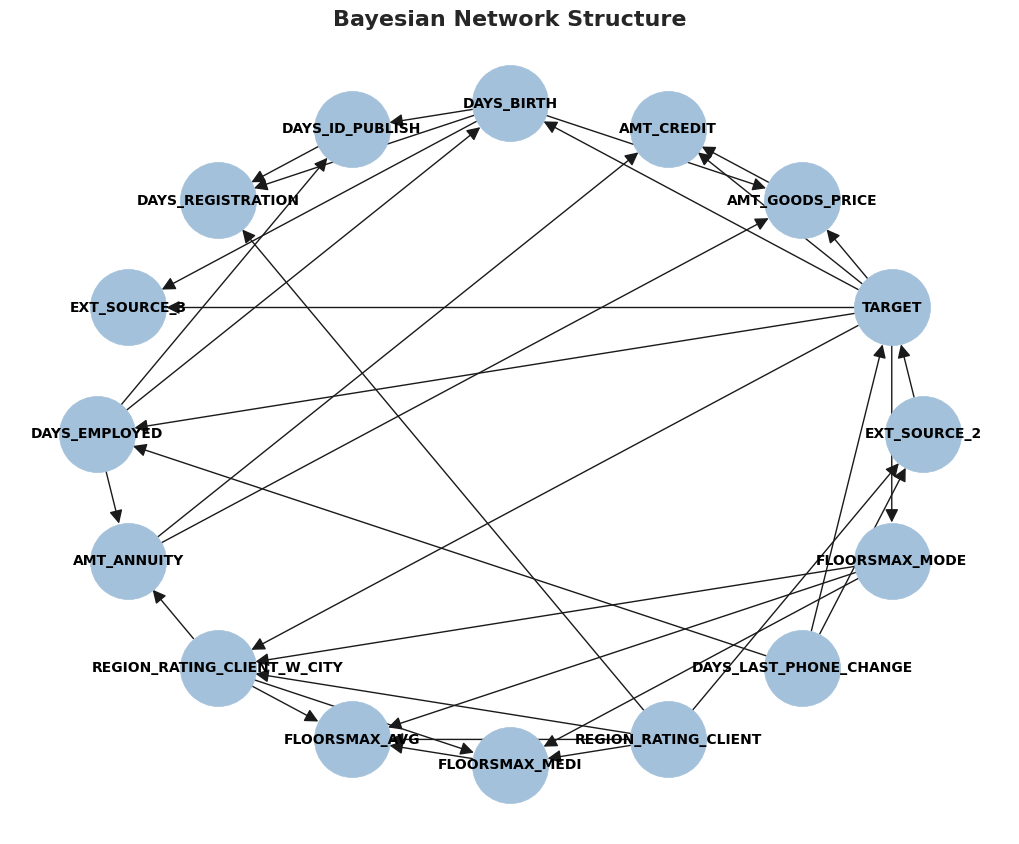

In [ ]:
pos = nx.circular_layout(model, scale=0.9)

plt.figure(figsize=(10, 8))
nx.draw(
    model,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="#A3C1DA",
    font_size=10,
    font_weight="bold",
    font_color="black",
    arrowsize=20
)

plt.title("Bayesian Network Structure", fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()